In [1]:
from dotenv import load_dotenv

load_dotenv()

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from typing import TypedDict,Literal
from langgraph.prebuilt import ToolNode
import json
from langgraph.graph import StateGraph,END,START
from langchain.tools import tool

In [3]:
class ToolCalling(TypedDict):
    
    query : str
    ans : str


In [6]:
@tool
def add(a: int,b: int) -> int:
    """For adding two numbers or when the + sign is between two numbers"""
    
    return a+b

In [7]:
def tool_or_respond(state: ToolCalling):
    llm_with_tools = llm.bind_tools([add])
    response = llm_with_tools.invoke(state['query'])
    
    return {'ans' : response}

In [8]:
llm_with_tools = llm.bind_tools([add])
response = llm_with_tools.invoke("Capital of china")

if response.tool_calls:
    print("here")
else:
    print('there')

there


In [9]:
def conditional_node(state: ToolCalling) -> Literal['Tool_Call','Selfknowledge']:
    response = state['ans']
    if response.tool_calls:
        return 'Tool_Call'
    else:
        return 'Selfknowledge'

In [10]:
def Selfknowledge(state: ToolCalling):
    query = state['query']
    prompt = f'Give the ans to the query: {query}'
    ans = llm.invoke(prompt)
    return {'ans':ans}

In [11]:
def Tool_Call(state: ToolCalling):
    response = state['ans']
    tool_map = {'add':add,'subtract':subtract}
    results = []
    for call in response.tool_calls:
        tool_name = call['name']  
        args = call['args']      
        print("tool_name: ",tool_name,"args: ",args)
        
        if not isinstance(args, dict):
            print(f"Arguments for {tool_name} are not a dict: {args}")
            continue 
            
        if tool_name in tool_map and args:
            try:
                result = tool_map[tool_name].func(**args)
                print("result:",result)
                results.append(result)
                print("results list:",results)
            except Exception as e:
                print(f"Error calling tool {tool_name}: {e}")
                
    if results:
        prompt = f"""Based on the tool execution results: {results}, provide a clear final answer."""
    else:
        prompt = "No tools were executed successfully."
    response = llm.invoke(prompt)
    return {'ans':response}

In [12]:
graph = StateGraph(ToolCalling)

graph.add_node('tool_or_respond',tool_or_respond)
graph.add_node("Tool_Call",Tool_Call)
graph.add_node("Selfknowledge",Selfknowledge)

graph.add_edge(START,"tool_or_respond")
graph.add_conditional_edges('tool_or_respond',conditional_node)
graph.add_edge("Tool_Call",END)
graph.add_edge('Selfknowledge',END)

In [13]:
workflow = graph.compile()

In [14]:
workflow.invoke({'query':"Capital of china"})

{'query': 'Capital of china',
 'ans': AIMessage(content='The capital of China is **Beijing**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--25ff5365-79d7-4d26-83a3-43be503d05bf-0', usage_metadata={'input_tokens': 11, 'output_tokens': 8, 'total_tokens': 38, 'input_token_details': {'cache_read': 0}})}

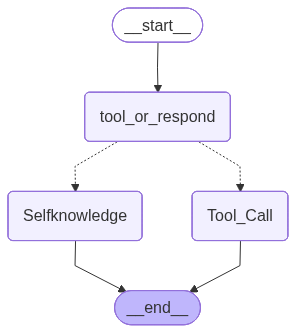

In [15]:
graph.compile()